In [1]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm

In [2]:
import os
import librosa
from tqdm import tqdm

# Define dataset directory
dataset_path = "voiceDataset"

# Function to extract emotion label from filename
def extract_label(filename):
    parts = filename.split("-")
    emotion_code = int(parts[2])
    emotion_map = {
        1: "neutral", 2: "calm", 3: "happy", 4: "sad",
        5: "angry", 6: "fearful", 7: "disgust", 8: "surprised"
    }
    return emotion_map.get(emotion_code, "unknown")

# Lists to store MFCC features and corresponding labels
mfcc_features = []
labels = []

# Loop through each audio file in the dataset
for root, dirs, files in os.walk(dataset_path):
    for file in tqdm(files):
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            try:
                # Load audio file
                signal, sr = librosa.load(file_path, sr=None)
                # Extract MFCCs
                mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
                mfcc = mfcc.T  # Transpose to shape (time, mfcc)
                mfcc_features.append(mfcc)
                labels.append(extract_label(file))
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:00<00:00, 177.06it/s]


In [3]:
from collections import Counter

print("Number of MFCC samples:", len(mfcc_features))
print("Number of labels:", len(labels))
print("Label distribution:", Counter(labels))

Number of MFCC samples: 2880
Number of labels: 2880
Label distribution: Counter({'angry': 384, 'fearful': 384, 'disgust': 384, 'sad': 384, 'surprised': 384, 'happy': 384, 'calm': 384, 'neutral': 192})


In [4]:
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Padding configuration
max_len = 200  # number of time steps (frames)
n_mfcc = 40    # number of MFCC features per frame

# Pad or truncate MFCC sequences to fixed length
padded_mfcc = []
for mfcc in mfcc_features:
    if mfcc.shape[0] < max_len:
        pad_width = max_len - mfcc.shape[0]
        padded = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
    else:
        padded = mfcc[:max_len]
    padded_mfcc.append(padded)

# Convert to numpy array then to torch tensor
X = torch.tensor(np.array(padded_mfcc), dtype=torch.float32)  # shape: [samples, time, mfcc]

# Encode string labels into integer classes
le = LabelEncoder()
y_encoded = le.fit_transform(labels)  # e.g. ['angry', 'happy', ...] → [0, 1, ...]
y = torch.tensor(y_encoded, dtype=torch.long)

# Split dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes and class labels
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print("Classes:", le.classes_)

X_train shape: torch.Size([2304, 200, 40])
y_train shape: torch.Size([2304])
Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [5]:
import torch.nn as nn
import torch

# Attention mechanism to focus on important time steps
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, lstm_output):
        # lstm_output: [batch_size, seq_len, hidden_dim * 2]
        attn_weights = torch.softmax(self.attn(lstm_output), dim=1)  # [batch_size, seq_len, 1]
        context = torch.sum(attn_weights * lstm_output, dim=1)       # [batch_size, hidden_dim * 2]
        return context, attn_weights

# Full BiLSTM + Attention model for emotion classification
class AdvancedEmotionModel(nn.Module):
    def __init__(self, input_dim=40, hidden_dim=128, num_layers=2, num_classes=8, dropout=0.3):
        super(AdvancedEmotionModel, self).__init__()

        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )

        self.attention = Attention(hidden_dim)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x: [batch, seq_len, input_dim]
        lstm_out, _ = self.bilstm(x)  # [batch, seq_len, hidden_dim * 2]
        context, attn_weights = self.attention(lstm_out)
        output = self.classifier(context)
        return output

In [6]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# Move model to MPS (Apple Silicon GPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = AdvancedEmotionModel().to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Training settings
num_epochs = 20
batch_size = 64

# Convert datasets into batches
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(all_labels, all_preds)
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_losses[-1]:.4f} Acc: {train_accuracies[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f} Acc: {val_accuracies[-1]:.4f}")

Epoch 1/20 | Train Loss: 1.7547 Acc: 0.3320 | Val Loss: 1.6924 Acc: 0.4948
Epoch 2/20 | Train Loss: 1.4117 Acc: 0.4865 | Val Loss: 1.5098 Acc: 0.4253
Epoch 3/20 | Train Loss: 1.1589 Acc: 0.5964 | Val Loss: 1.1463 Acc: 0.5955
Epoch 4/20 | Train Loss: 0.9502 Acc: 0.6710 | Val Loss: 1.5505 Acc: 0.4861
Epoch 5/20 | Train Loss: 0.7775 Acc: 0.7370 | Val Loss: 0.8203 Acc: 0.7240
Epoch 6/20 | Train Loss: 0.6342 Acc: 0.7973 | Val Loss: 0.9602 Acc: 0.6476
Epoch 7/20 | Train Loss: 0.5422 Acc: 0.8260 | Val Loss: 0.5617 Acc: 0.8212
Epoch 8/20 | Train Loss: 0.4638 Acc: 0.8524 | Val Loss: 0.7669 Acc: 0.7170
Epoch 9/20 | Train Loss: 0.4027 Acc: 0.8720 | Val Loss: 0.8333 Acc: 0.7135
Epoch 10/20 | Train Loss: 0.3157 Acc: 0.8980 | Val Loss: 0.5857 Acc: 0.8003
Epoch 11/20 | Train Loss: 0.2699 Acc: 0.9175 | Val Loss: 0.5425 Acc: 0.8403
Epoch 12/20 | Train Loss: 0.2176 Acc: 0.9366 | Val Loss: 0.5991 Acc: 0.8021
Epoch 13/20 | Train Loss: 0.2060 Acc: 0.9392 | Val Loss: 0.6854 Acc: 0.7795
Epoch 14/20 | Train L

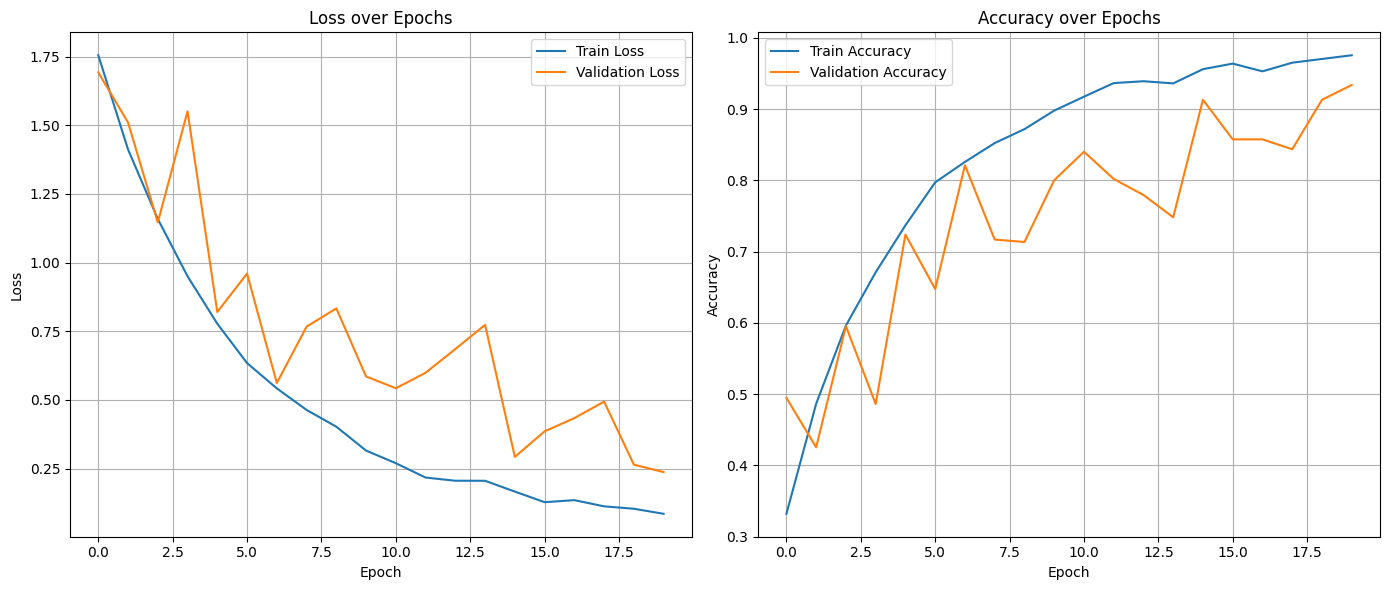

In [7]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Classification Report:

              precision    recall  f1-score   support

       angry       0.99      0.93      0.96        76
        calm       0.87      0.98      0.92        94
     disgust       0.95      0.96      0.95        73
     fearful       0.93      0.94      0.94        90
       happy       1.00      0.92      0.96        71
     neutral       0.93      0.78      0.85        36
         sad       0.96      0.86      0.91        64
   surprised       0.89      1.00      0.94        72

    accuracy                           0.93       576
   macro avg       0.94      0.92      0.93       576
weighted avg       0.94      0.93      0.93       576



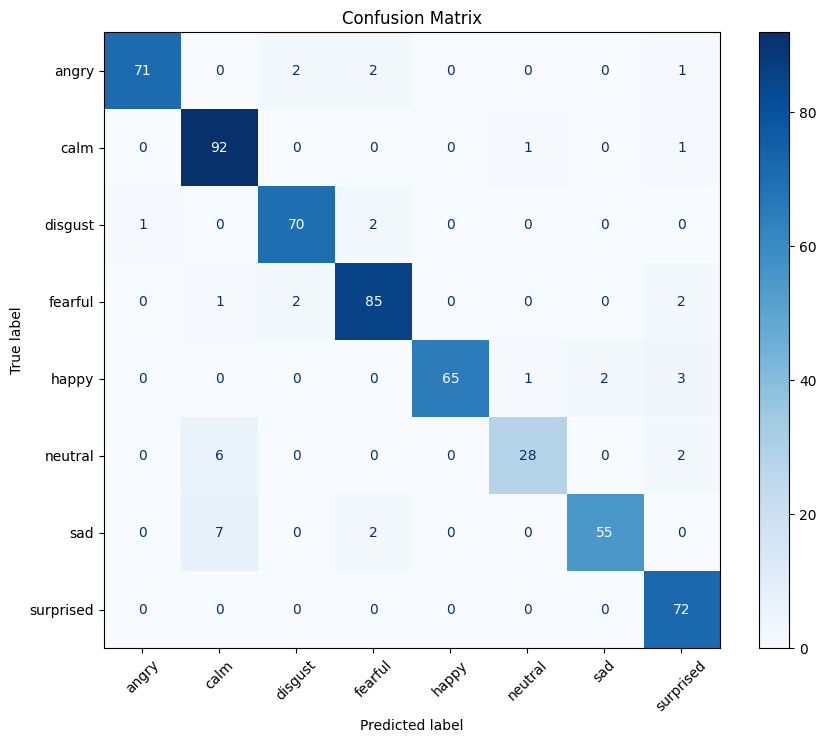

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure evaluation mode
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(labels.numpy())

# Inverse transform to get original string labels
true_labels = le.inverse_transform(all_true)
pred_labels = le.inverse_transform(all_preds)

# Classification Report
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [9]:
# Save model state_dict and label encoder
model_save_path = "voice_emotion_model.pt"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: voice_emotion_model.pt
